# Analysis with XGBoost

In this botebook, I will analyze data 3 '3year.arff' using the Ensemble Method 'XGBoost'.

Since my business goal is identifying whether the company will bankrupt or not, I will focus on the 'precision' on my predictions. Besides 'precision' metric, I will also keep an eye on 'f1', 'AUC' and 'accuracy' values.  

## Load Libraries

In [2]:
# Import base libraries
import pandas as pd
import numpy as np
from scipy.io import arff

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score

from functions import *

from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

## Load Data

There are five data files: 
    * data1, 1year.arff 
    * data2, 2year.arff 
    * data3, 3year.arff
    * data4, 4year.arff
    * data5, 5year.arff

Initially, I will explore the models on data3. After determing the final model design, I will apply it on other datasets and compare te results.

No cleaning applied to data. XGBoost Classifier can handle the missing values.

In [4]:
# Load data
data3 = arff.loadarff('data/3year.arff')
df3 = pd.DataFrame(data3[0])

# Change label/class  type
df3['class'] = df3['class'].astype('int64')

df3.shape

(10503, 65)

## Pre-process

In [6]:
# Assign target and predictor

y = df3['class']
X = df3.drop('class', axis=1)

In [7]:
# Sepearate data into train and test splist

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

print('X_train shape = ', X_train.shape)
print('y_train shape = ', y_train.shape)
print('X_test shape = ', X_test.shape)
print('y_test shape = ', y_test.shape)

X_train shape =  (8402, 64)
y_train shape =  (8402,)
X_test shape =  (2101, 64)
y_test shape =  (2101,)


In [8]:
# Scale/Normalize the predictor variables

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

## Baseline Model - XGBoost


In [49]:
# Instantiate, and fit XGBClassifier

xgb = XGBClassifier(eval_metric='logloss', random_state=42) #'logloss' is default, but specified to stop warning
xgb.fit(X_train, y_train)

print('Data3:\n')
print('Training Data:\n', classification_report(y_train, xgb.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1994
           1       0.93      0.47      0.62       107

    accuracy                           0.97      2101
   macro avg       0.95      0.73      0.80      2101
weighted avg       0.97      0.97      0.97      2101



**Comments**

* According to testing data results, the model performance in identfying the non-bankruptcy companies (class 0) is very good. 
* However, the identification of the bankruptcy companies (class 1) is not as good.
* The class imbalance is probbaly the reason for the class 0/1 performance difference.
* There is a huge overfitting, especially on class 1 predictions.

### Class Imbalance

In [11]:
#Check Class Imbalance
df3['class'].value_counts(normalize=True)

0    0.952871
1    0.047129
Name: class, dtype: float64

In [12]:
# Explore scale_pos_weight

val_counts = df3['class'].value_counts()
ratio_imbalance = val_counts[0]/val_counts[1]
sqrt_ratio_imbalance = np.sqrt(val_counts[0]/val_counts[1])

print('imbalance ratio:', ratio_imbalance)
print('sqrt of imbalance ratio:', sqrt_ratio_imbalance)

imbalance ratio: 20.21818181818182
sqrt of imbalance ratio: 4.496463256625347


In [10]:
#Treat Imbalance, scale_pos_weight = imbalance ratio

xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=20, random_state=42)
xgb.fit(X_train, y_train)

print('Data3, scale_pos_weight = imbalance ratio:\n')
print('Training Data:\n', classification_report(y_train, xgb.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3, scale_pos_weight = imbalance ratio:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1994
           1       0.83      0.50      0.62       107

    accuracy                           0.97      2101
   macro avg       0.90      0.74      0.80      2101
weighted avg       0.97      0.97      0.97      2101



In [12]:
#Treat Imbalance, scale_pos_weight = sqrt of imbalance ratio

xgb = XGBClassifier(eval_metric='logloss', scale_pos_weight=4.5, random_state=42)
xgb.fit(X_train, y_train)

print('Data3, Imbalance addressed, scale_pos_weight = 4.5 (sqrt of imbalance ratio):\n')
print('Training Data:\n', classification_report(y_train, xgb.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, xgb.predict(X_test)))

Data3, Imbalance addressed, scale_pos_weight = 4.5 (sqrt of imbalance ratio):

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.95      0.52      0.67       107

    accuracy                           0.97      2101
   macro avg       0.96      0.76      0.83      2101
weighted avg       0.97      0.97      0.97      2101



,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
scale_pos_weight=1 Train,1.000,1.000,1.000,1.000,1.000,0.074,0.079914
Test,0.971,0.926,0.467,0.621,0.941,0.074,0.079914
scale_pos_weight=3 Train,1.000,1.000,1.000,1.000,1.000,0.093,0.102536
Test,0.970,0.907,0.458,0.609,0.935,0.093,0.102536
scale_pos_weight=4.5 Train,1.000,1.000,1.000,1.000,1.000,0.051,0.053741
Test,0.974,0.949,0.523,0.675,0.935,0.051,0.053741
scale_pos_weight=6 Train,1.000,1.000,1.000,1.000,1.000,0.102,0.113586
Test,0.971,0.898,0.495,0.639,0.936,0.102,0.113586
scale_pos_weight=10 Train,1.000,1.000,1.000,1.000,1.000,0.118,0.133787


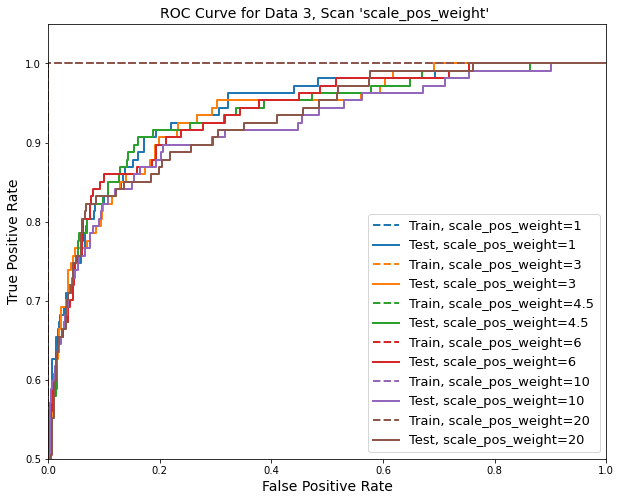

In [9]:
# Compare 'scale_pos_weight' values

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42
}

scanParam = 'scale_pos_weight'

scanList = [1, 3, 4.5, 6, 10, 20]
#scanList = [1, 4.5, 20]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 1)

**Comments**
* Using 'scale_pos_weight' increased the model performance on testing data.
* I choose to use scale_pos_weight = 4.5 in my analysis, since it has the highest precision, and smallest precision overfitting.
    * sqrt of imbalance ratio = 4.5
* Overfitting continues.

### Model 1: Baseline Model with selected scale_pos_weight

In [8]:
# Model 1: Baseline Model with selected scale_pos_weight

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5
}

model_1 = XGBClassifier(**xgbParams)
model_1.fit(X_train, y_train)

print('Data3, Model 1:\n')
print('Training Data:\n', classification_report(y_train, model_1.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, model_1.predict(X_test)))

model_1.save_model('saved_model_history/xgb_model_1.json')

Data3, Model 1:

Training Data:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      8014
           1       1.00      1.00      1.00       388

    accuracy                           1.00      8402
   macro avg       1.00      1.00      1.00      8402
weighted avg       1.00      1.00      1.00      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99      1994
           1       0.95      0.52      0.67       107

    accuracy                           0.97      2101
   macro avg       0.96      0.76      0.83      2101
weighted avg       0.97      0.97      0.97      2101



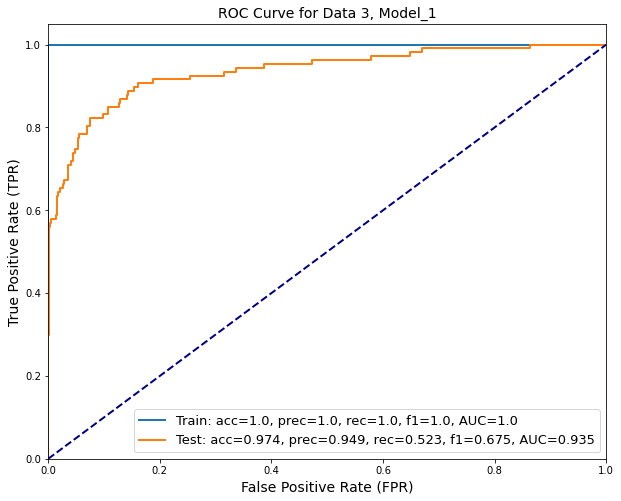

In [9]:
ROC_curve_train_test(3, X_train, y_train, X_test, y_test, model_1, 'Model_1', 1)

In [32]:
model_1.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=4.5, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

## Overfitting

The ovefitting looks a like a main issue at this point.

I will try to control overfitting by tuning the XGBoost Classifier Parameters.

The paramaters, which can affect the overfitting, can be grouped in four categories:

1. Pruning:
    * max_depth
    * min_child_weight
    * gamma
2. Regularization:
    * reg_lambda
    * reg_alpha
    * learning_rate
    * max_delta_step
3. Sampling
    * subsample
    * colsample_bytree
4. Early Stopping
    * early_stopping_rounds


## Control Overfitting with Pruning

### max_depth

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
max_depth=1 Train,0.953,0.485,0.454,0.469,0.916,0.023,0.049784
Test,0.945,0.462,0.449,0.455,0.898,0.023,0.049784
max_depth=2 Train,0.977,0.746,0.755,0.750,0.987,0.111,0.174803
Test,0.961,0.635,0.570,0.601,0.936,0.111,0.174803
max_depth=3 Train,0.996,0.936,0.979,0.957,1.000,0.176,0.231579
Test,0.968,0.760,0.533,0.626,0.931,0.176,0.231579
max_depth=4 Train,1.000,0.992,1.000,0.996,1.000,0.168,0.203883
Test,0.970,0.824,0.523,0.640,0.936,0.168,0.203883
max_depth=5 Train,1.000,1.000,1.000,1.000,1.000,0.164,0.196172


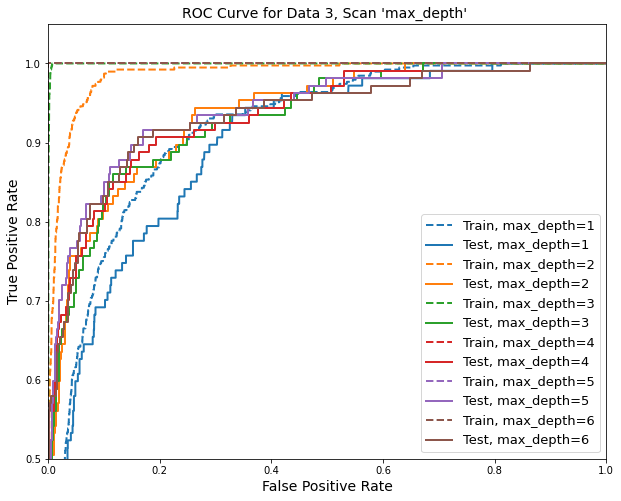

In [10]:
#Scan max_depth

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5
}

scanParam = 'max_depth'

scanList = [1, 2, 3, 4, 5, 6]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

### min_child_weight

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
min_child_weight=1 Train,1.000,1.000,1.000,1.000,1.000,0.051,0.053741
Test,0.974,0.949,0.523,0.675,0.935,0.051,0.053741
min_child_weight=2 Train,1.000,1.000,1.000,1.000,1.000,0.098,0.108647
Test,0.972,0.902,0.514,0.655,0.933,0.098,0.108647
min_child_weight=3 Train,1.000,1.000,1.000,1.000,1.000,0.081,0.088139
Test,0.974,0.919,0.533,0.675,0.948,0.081,0.088139
min_child_weight=4 Train,1.000,1.000,1.000,1.000,1.000,0.085,0.092896
Test,0.972,0.915,0.505,0.651,0.931,0.085,0.092896


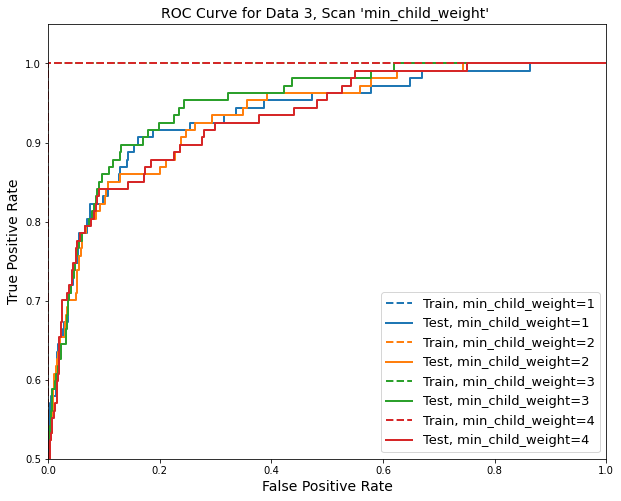

In [12]:
#Scan min_child_weight

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
}

scanParam = 'min_child_weight'

scanList = [1, 2, 3, 4]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

### gamma

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
gamma=0 Train,1.000,1.000,1.000,1.000,1.000,0.051,0.053741
Test,0.974,0.949,0.523,0.675,0.935,0.051,0.053741
gamma=0.1 Train,1.000,1.000,1.000,1.000,1.000,0.067,0.071811
Test,0.974,0.933,0.523,0.671,0.933,0.067,0.071811
gamma=0.2 Train,1.000,1.000,1.000,1.000,1.000,0.123,0.140251
Test,0.972,0.877,0.533,0.663,0.938,0.123,0.140251
gamma=0.3 Train,1.000,1.000,1.000,1.000,1.000,0.066,0.070664
Test,0.974,0.934,0.533,0.679,0.934,0.066,0.070664
gamma=0.4 Train,1.000,1.000,1.000,1.000,1.000,0.052,0.054852


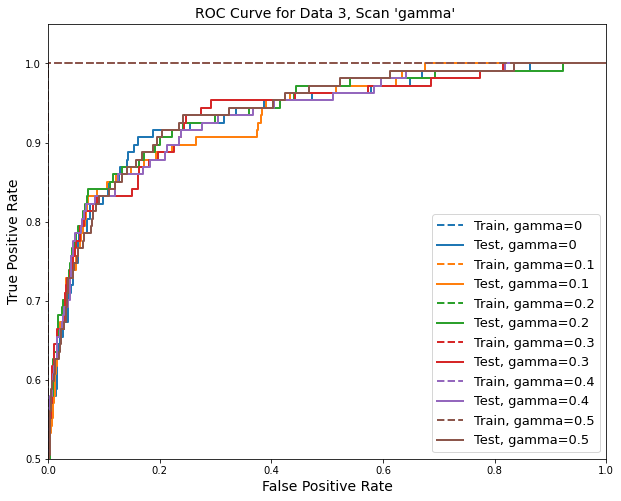

In [13]:
#Scan gamma

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,

}

scanParam = 'gamma'

scanList = [0, 0.1, 0.2, 0.3, 0.4, 0.5]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

### Comments on Pruning

max_depth:

* When considered all metrics, the overfitting decreases as the the max_depth decreases.
* However, the model performance and precision also drops, as max_depth decreases.
* I choose to use max_depth=2.

min_child_weight:

* The overfitting dependency on min_child_weight is not clear.
* As the min_child_weight increases, the model performance decreases.
* I choose to use min_child_weight=1 

gamma:

* The overfitting dependency on gamma is not clear.
* As gamma increases, the model performance decreases.
* I choose to use gamma=0 

### Model 2: Model after Pruning

In [10]:
# Model 2: Model after pruning

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 2,
    'min_child_weight': 1,
    'gamma': 0
}

model_2 = XGBClassifier(**xgbParams)
model_2.fit(X_train, y_train)

print('Data3, Model 2:\n')
print('Training Data:\n', classification_report(y_train, model_2.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, model_2.predict(X_test)))

model_2.save_model('saved_model_history/xgb_model_2.json')

Data3, Model 2:

Training Data:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      8014
           1       0.75      0.76      0.75       388

    accuracy                           0.98      8402
   macro avg       0.87      0.87      0.87      8402
weighted avg       0.98      0.98      0.98      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      1994
           1       0.64      0.57      0.60       107

    accuracy                           0.96      2101
   macro avg       0.81      0.78      0.79      2101
weighted avg       0.96      0.96      0.96      2101



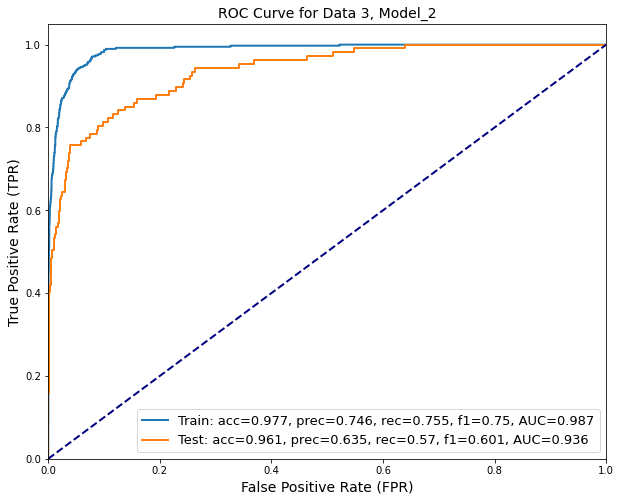

In [11]:
ROC_curve_train_test(3, X_train, y_train, X_test, y_test, model_2, 'Model_2', 1)

In [16]:
model_2.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=2, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=4.5, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

## Control Overfitting with Regularization

### reg_lambda

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_lambda=0 Train,0.978,0.769,0.740,0.754,0.987,0.084,0.122628
Test,0.965,0.685,0.570,0.622,0.932,0.084,0.122628
reg_lambda=0.2 Train,0.979,0.773,0.765,0.769,0.987,0.144,0.228935
Test,0.961,0.629,0.570,0.598,0.927,0.144,0.228935
reg_lambda=0.4 Train,0.977,0.759,0.745,0.752,0.987,0.092,0.137931
Test,0.963,0.667,0.561,0.609,0.928,0.092,0.137931
reg_lambda=0.6 Train,0.978,0.761,0.755,0.758,0.987,0.125,0.196541
Test,0.962,0.636,0.589,0.612,0.927,0.125,0.196541
reg_lambda=0.8 Train,0.978,0.764,0.758,0.761,0.987,0.105,0.159332


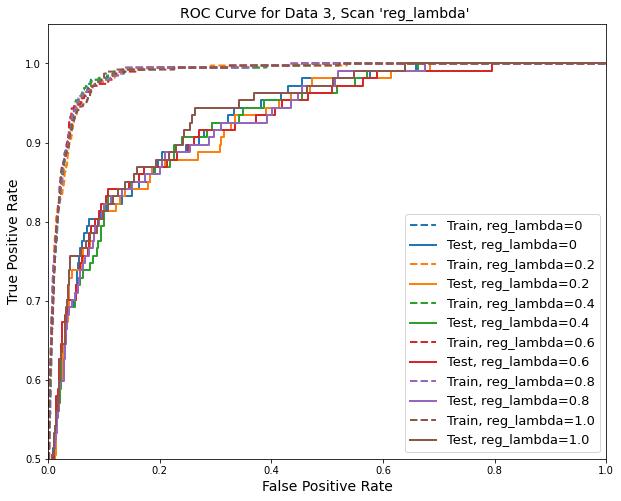

In [14]:
#Scan reg_lambda, 
#Model 2: max_depth=2

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 2,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_alpha': 0
}

scanParam = 'reg_lambda'

scanList = [0, .2, .4, .6, .8, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_lambda=10 Train,0.993,0.902,0.946,0.923,0.999,0.152,0.202667
Test,0.968,0.750,0.561,0.642,0.928,0.152,0.202667
reg_lambda=100 Train,0.983,0.821,0.802,0.811,0.993,0.144,0.212703
Test,0.965,0.677,0.589,0.630,0.928,0.144,0.212703
reg_lambda=200 Train,0.978,0.773,0.727,0.749,0.985,0.085,0.123547
Test,0.966,0.688,0.598,0.640,0.923,0.085,0.123547
reg_lambda=300 Train,0.975,0.747,0.698,0.722,0.980,0.047,0.067143
Test,0.966,0.700,0.589,0.640,0.924,0.047,0.067143
reg_lambda=500 Train,0.972,0.714,0.649,0.680,0.970,0.047,0.070465


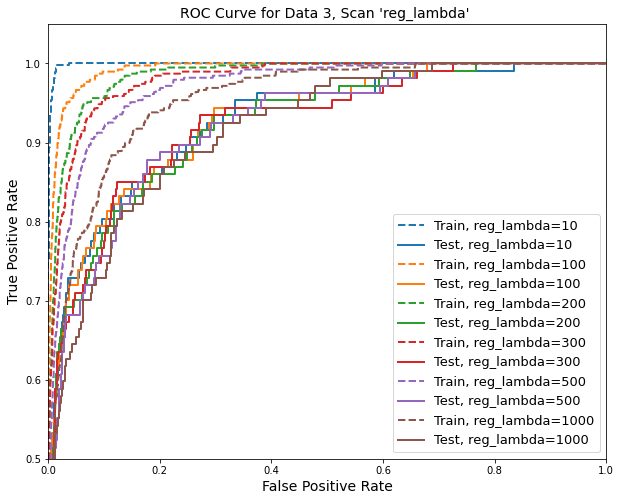

In [16]:
#Scan reg_lambda, stronger L2
#max_depth=3

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_alpha': 0
}

scanParam = 'reg_lambda'

scanList = [10, 100, 200, 300, 500, 1000]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_lambda=100 Train,0.993,0.900,0.951,0.925,0.999,0.229,0.341282
Test,0.963,0.671,0.533,0.594,0.928,0.229,0.341282
reg_lambda=200 Train,0.987,0.867,0.858,0.863,0.996,0.169,0.242120
Test,0.965,0.698,0.561,0.622,0.932,0.169,0.242120
reg_lambda=300 Train,0.984,0.829,0.812,0.820,0.993,0.124,0.175887
Test,0.966,0.705,0.579,0.636,0.935,0.124,0.175887
reg_lambda=500 Train,0.978,0.783,0.716,0.748,0.986,0.067,0.093575
Test,0.967,0.716,0.589,0.646,0.927,0.067,0.093575
reg_lambda=1000 Train,0.972,0.725,0.626,0.672,0.970,0.046,0.067747


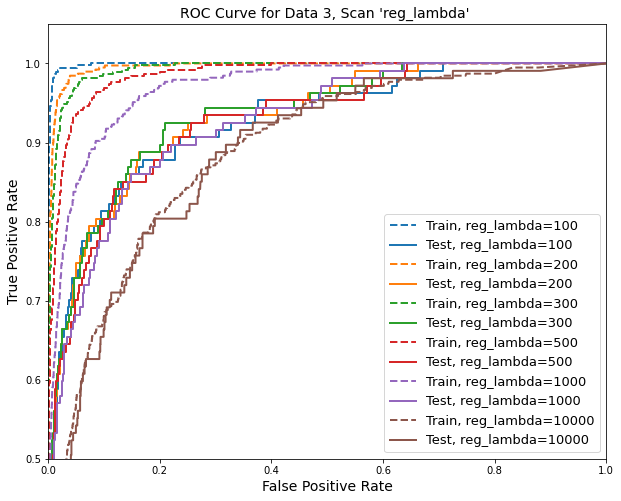

In [17]:
#Scan reg_lambda, stronger L2
#max_depth=4

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 4,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_alpha': 0
}

scanParam = 'reg_lambda'

scanList = [100, 200, 300, 500, 1000, 10000]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_lambda=300 Train,0.990,0.907,0.879,0.893,0.997,0.225,0.329912
Test,0.964,0.682,0.542,0.604,0.934,0.225,0.329912
reg_lambda=500 Train,0.984,0.859,0.786,0.821,0.993,0.188,0.280179
Test,0.962,0.671,0.514,0.582,0.930,0.188,0.280179
reg_lambda=1000.0 Train,0.977,0.781,0.698,0.737,0.980,0.110,0.163934
Test,0.962,0.671,0.514,0.582,0.924,0.110,0.163934
reg_lambda=10000.0 Train,0.964,0.743,0.335,0.462,0.895,0.045,0.064470
Test,0.957,0.698,0.280,0.400,0.886,0.045,0.064470
reg_lambda=100000.0 Train,0.965,0.845,0.309,0.453,0.781,0.045,0.056250


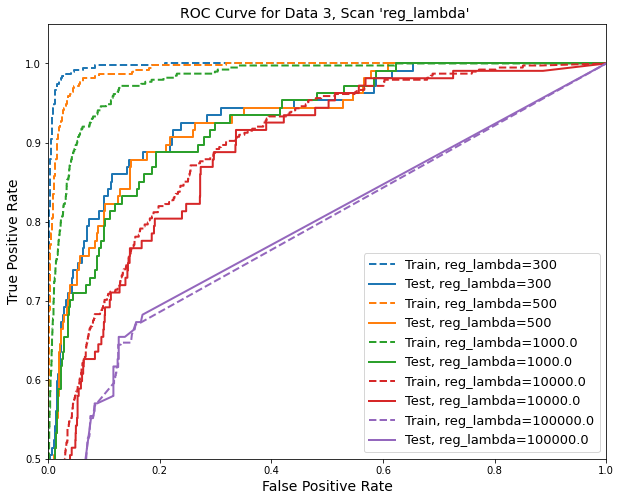

In [34]:
#Scan reg_lambda, stronger L2
#max_depth=5

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_alpha': 0
}

scanParam = 'reg_lambda'

scanList = [300, 500, 1e3, 1e4, 1e5]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_lambda=500 Train,0.989,0.904,0.848,0.875,0.996,0.157,0.210174
Test,0.967,0.747,0.523,0.615,0.934,0.157,0.210174
reg_lambda=1000.0 Train,0.980,0.818,0.740,0.777,0.985,0.151,0.226387
Test,0.962,0.667,0.505,0.574,0.927,0.151,0.226387
reg_lambda=10000.0 Train,0.965,0.774,0.353,0.485,0.900,0.063,0.088608
Test,0.958,0.711,0.299,0.421,0.886,0.063,0.088608
reg_lambda=100000.0 Train,0.967,0.910,0.314,0.467,0.792,0.096,0.117936
Test,0.962,0.814,0.327,0.467,0.796,0.096,0.117936


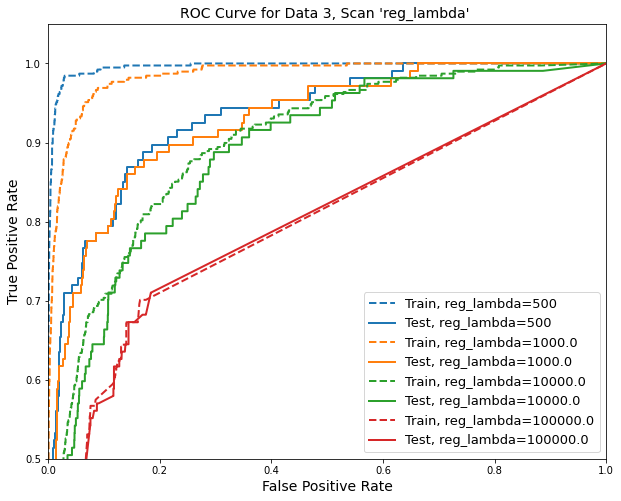

In [35]:
#Scan reg_lambda, stronger L2
#max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_alpha': 0
}

scanParam = 'reg_lambda'

scanList = [500, 1e3, 1e4, 1e5]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

### reg_alpha

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_alpha=0 Train,0.978,0.769,0.740,0.754,0.987,0.084,0.122628
Test,0.965,0.685,0.570,0.622,0.932,0.084,0.122628
reg_alpha=0.2 Train,0.978,0.769,0.755,0.762,0.988,0.078,0.112880
Test,0.966,0.691,0.607,0.647,0.924,0.078,0.112880
reg_alpha=0.4 Train,0.975,0.722,0.745,0.734,0.987,0.066,0.100610
Test,0.962,0.656,0.551,0.599,0.921,0.066,0.100610
reg_alpha=0.6 Train,0.976,0.739,0.758,0.748,0.986,0.058,0.085169
Test,0.965,0.681,0.579,0.626,0.930,0.058,0.085169
reg_alpha=0.8 Train,0.978,0.766,0.758,0.762,0.988,0.117,0.180277


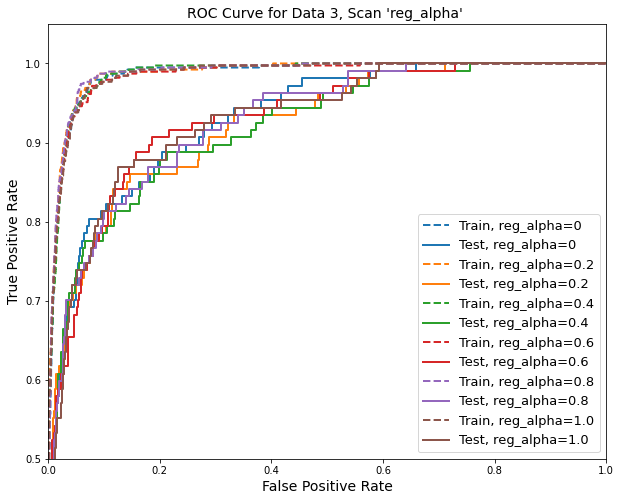

In [18]:
#Scan reg_alpha, 
#Model 2: max_depth=2

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 2,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0
}

scanParam = 'reg_alpha'

scanList = [0, .2, .4, .6, .8, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_alpha=1 Train,0.997,0.955,0.977,0.966,1.000,0.208,0.278447
Test,0.968,0.747,0.551,0.634,0.930,0.208,0.278447
reg_alpha=10 Train,0.992,0.896,0.930,0.913,0.998,0.177,0.246175
Test,0.968,0.719,0.598,0.653,0.924,0.177,0.246175
reg_alpha=20 Train,0.984,0.829,0.827,0.828,0.994,0.131,0.187679
Test,0.965,0.698,0.561,0.622,0.929,0.131,0.187679
reg_alpha=30 Train,0.975,0.749,0.683,0.714,0.980,0.033,0.046089
Test,0.967,0.716,0.589,0.646,0.925,0.033,0.046089
reg_alpha=35 Train,0.971,0.705,0.647,0.675,0.974,0.012,0.017316


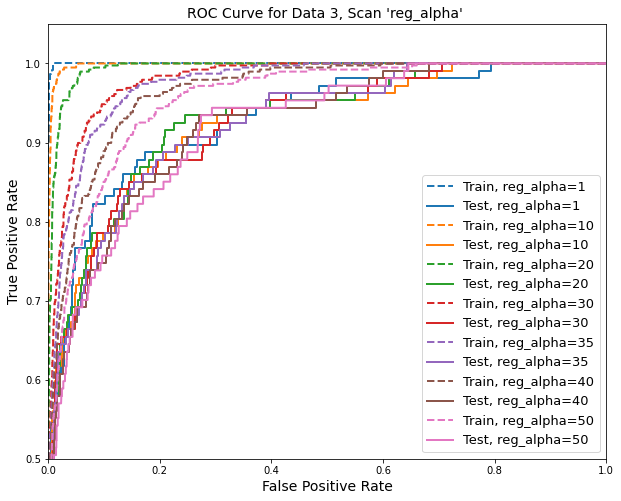

In [19]:
#Scan reg_alpha, with stronger L1
#max_depth=3

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0
}

scanParam = 'reg_alpha'

scanList = [1, 10, 20, 30, 35, 40, 50]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_alpha=10 Train,0.997,0.944,0.992,0.967,1.000,0.185,0.243742
Test,0.969,0.759,0.561,0.645,0.937,0.185,0.243742
reg_alpha=20 Train,0.988,0.865,0.879,0.872,0.997,0.156,0.220028
Test,0.966,0.709,0.570,0.632,0.929,0.156,0.220028
reg_alpha=30 Train,0.978,0.793,0.722,0.756,0.987,0.101,0.145954
Test,0.966,0.692,0.589,0.636,0.926,0.101,0.145954
reg_alpha=40 Train,0.974,0.737,0.673,0.704,0.980,0.028,0.039492
Test,0.966,0.709,0.570,0.632,0.922,0.028,0.039492
reg_alpha=50 Train,0.972,0.722,0.629,0.672,0.966,0.026,0.037356


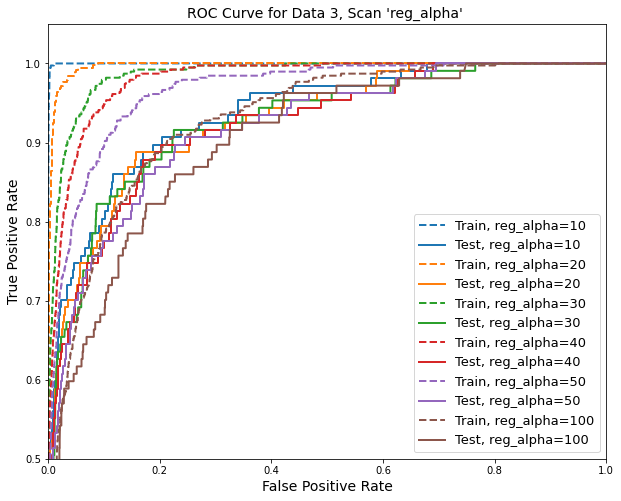

In [20]:
#Scan reg_alpha, with stronger L1
#max_depth=4

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 4,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0
}

scanParam = 'reg_alpha'

scanList = [10, 20, 30, 40, 50, 100]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_alpha=30 Train,0.983,0.834,0.791,0.812,0.992,0.118,0.164804
Test,0.966,0.716,0.542,0.617,0.929,0.118,0.164804
reg_alpha=40 Train,0.979,0.806,0.716,0.759,0.984,0.092,0.128852
Test,0.966,0.714,0.561,0.628,0.929,0.092,0.128852
reg_alpha=50 Train,0.976,0.756,0.696,0.725,0.975,0.036,0.050000
Test,0.966,0.720,0.551,0.624,0.929,0.036,0.050000
reg_alpha=100 Train,0.966,0.689,0.497,0.578,0.936,-0.007,-0.010057
Test,0.962,0.696,0.449,0.545,0.902,-0.007,-0.010057
reg_alpha=150 Train,0.963,0.688,0.381,0.491,0.913,0.037,0.056836


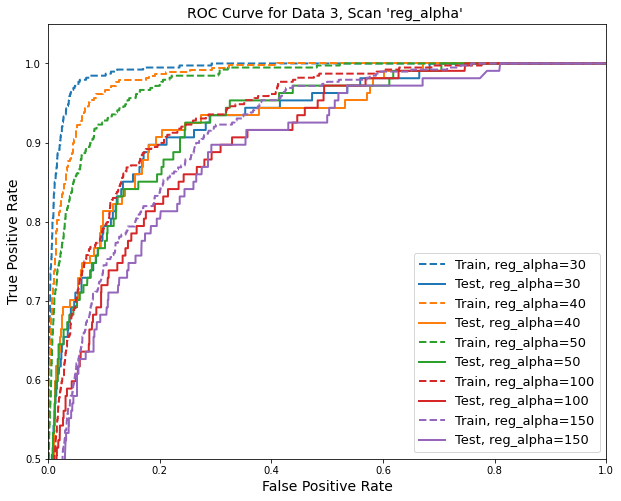

In [36]:
#Scan reg_alpha, with stronger L1
#max_depth=5

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0
}

scanParam = 'reg_alpha'

scanList = [30, 40, 50, 100, 150]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
reg_alpha=50 Train,0.976,0.770,0.698,0.732,0.980,0.103,0.154423
Test,0.961,0.667,0.486,0.562,0.932,0.103,0.154423
reg_alpha=100 Train,0.970,0.735,0.536,0.620,0.942,0.054,0.079295
Test,0.961,0.681,0.439,0.534,0.904,0.054,0.079295
reg_alpha=150 Train,0.965,0.738,0.392,0.512,0.919,0.088,0.135385
Test,0.958,0.650,0.364,0.467,0.891,0.088,0.135385
reg_alpha=200 Train,0.961,0.681,0.281,0.398,0.900,0.000,0.000000
Test,0.957,0.681,0.299,0.416,0.881,0.000,0.000000


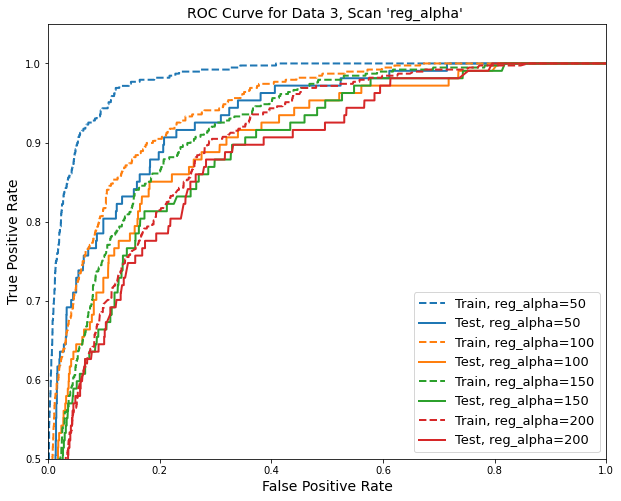

In [37]:
#Scan reg_alpha, with stronger L1
#max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0
}

scanParam = 'reg_alpha'

scanList = [50, 100, 150, 200]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

### learning_rate

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
learning_rate=0.05 Train,0.959,0.582,0.423,0.490,0.912,0.030,0.054348
Test,0.953,0.552,0.449,0.495,0.898,0.030,0.054348
learning_rate=0.1 Train,0.964,0.627,0.528,0.573,0.944,0.016,0.026187
Test,0.959,0.611,0.514,0.558,0.919,0.016,0.026187
learning_rate=0.15 Train,0.966,0.644,0.601,0.621,0.960,0.023,0.037037
Test,0.960,0.621,0.551,0.584,0.914,0.023,0.037037
learning_rate=0.2 Train,0.973,0.720,0.662,0.690,0.976,0.053,0.079460
Test,0.963,0.667,0.542,0.598,0.926,0.053,0.079460
learning_rate=0.25 Train,0.973,0.710,0.719,0.714,0.981,0.086,0.137821


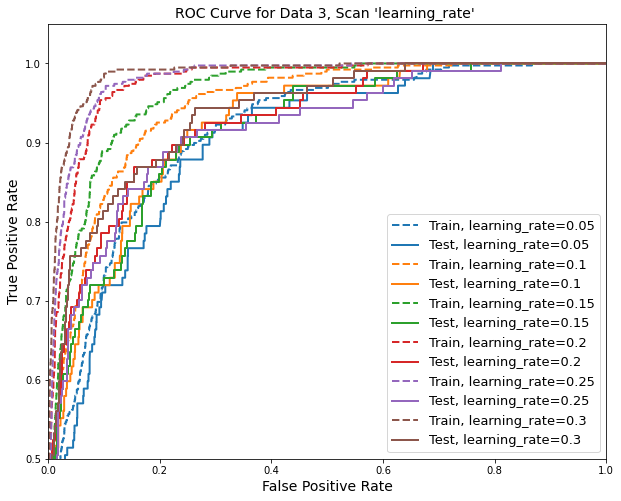

In [21]:
#Scan learning_rate, 
#Model 2: max_depth=2, Default L1 & L2 (reg_lambda=1, reg_alpha=0)

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 2,
    'min_child_weight': 1,
    'gamma': 0,
}

scanParam = 'learning_rate'

scanList = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
learning_rate=0.05 Train,0.968,0.685,0.554,0.613,0.961,0.051,0.080442
Test,0.960,0.634,0.486,0.550,0.914,0.051,0.080442
learning_rate=0.1 Train,0.977,0.780,0.686,0.730,0.984,0.093,0.135371
Test,0.964,0.687,0.533,0.600,0.929,0.093,0.135371
learning_rate=0.15 Train,0.983,0.842,0.781,0.810,0.993,0.156,0.227405
Test,0.964,0.686,0.551,0.611,0.927,0.156,0.227405
learning_rate=0.2 Train,0.990,0.896,0.892,0.894,0.998,0.171,0.235862
Test,0.966,0.725,0.542,0.620,0.921,0.171,0.235862
learning_rate=0.25 Train,0.993,0.928,0.930,0.929,0.999,0.169,0.222661


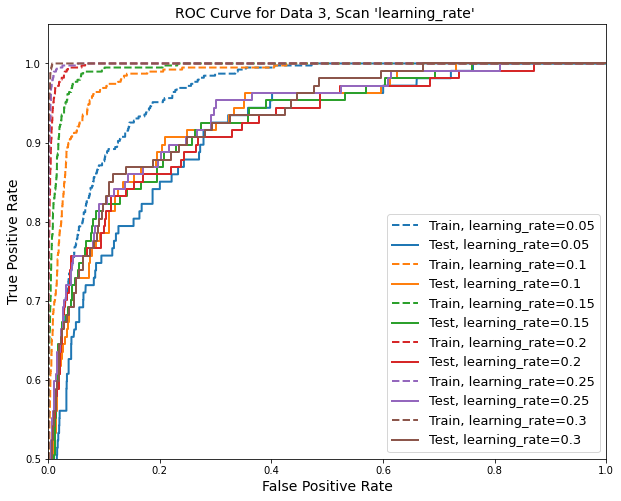

In [22]:
#Scan learning_rate, 
# max_depth=3, Default L1 & L2 (reg_lambda=1, reg_alpha=0)

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
}

scanParam = 'learning_rate'

scanList = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
learning_rate=0.05 Train,0.965,0.658,0.521,0.581,0.941,0.018,0.028125
Test,0.960,0.640,0.514,0.570,0.911,0.018,0.028125
learning_rate=0.1 Train,0.971,0.724,0.601,0.656,0.964,0.050,0.074184
Test,0.963,0.674,0.542,0.601,0.922,0.050,0.074184
learning_rate=0.15 Train,0.973,0.734,0.655,0.692,0.976,0.041,0.059163
Test,0.965,0.693,0.570,0.626,0.925,0.041,0.059163
learning_rate=0.2 Train,0.975,0.758,0.686,0.720,0.979,0.045,0.063114
Test,0.967,0.713,0.579,0.639,0.930,0.045,0.063114
learning_rate=0.25 Train,0.974,0.741,0.673,0.705,0.979,0.012,0.016461


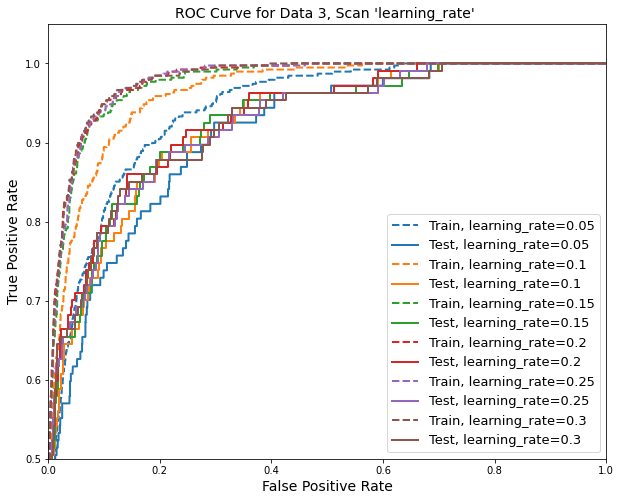

In [27]:
#Scan learning_rate, 
# max_depth=3, reg_lambda=0, reg_alpha=30

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 30,
}

scanParam = 'learning_rate'

scanList = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
learning_rate=0.05 Train,0.971,0.734,0.577,0.646,0.962,0.054,0.079412
Test,0.962,0.680,0.477,0.560,0.920,0.054,0.079412
learning_rate=0.1 Train,0.974,0.751,0.655,0.700,0.974,0.011,0.014865
Test,0.967,0.740,0.533,0.620,0.928,0.011,0.014865
learning_rate=0.15 Train,0.975,0.768,0.657,0.708,0.975,0.052,0.072626
Test,0.966,0.716,0.542,0.617,0.931,0.052,0.072626
learning_rate=0.2 Train,0.976,0.770,0.673,0.718,0.976,-0.003,-0.003881
Test,0.969,0.773,0.542,0.637,0.929,-0.003,-0.003881
learning_rate=0.25 Train,0.975,0.756,0.662,0.706,0.976,0.045,0.063291


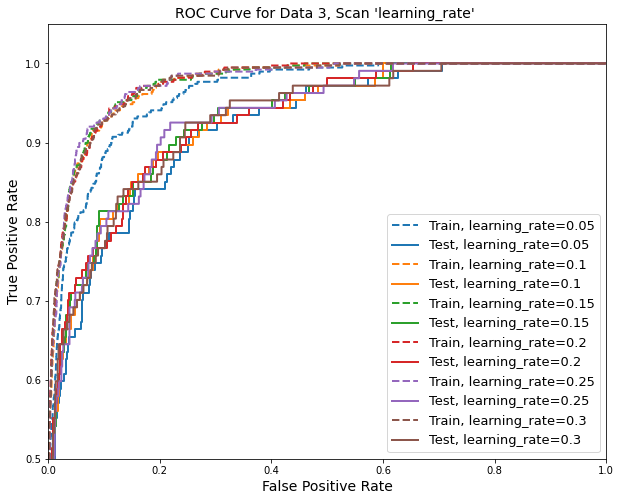

In [39]:
#Scan learning_rate, 
# max_depth=5, reg_lambda=0, reg_alpha=50

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
}

scanParam = 'learning_rate'

scanList = [0.05, 0.10, 0.15, 0.20, 0.25, 0.30]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

### max_delta_step

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
max_delta_step=0 Train,0.977,0.746,0.755,0.750,0.987,0.111,0.174803
Test,0.961,0.635,0.570,0.601,0.936,0.111,0.174803
max_delta_step=1 Train,0.974,0.733,0.693,0.713,0.984,0.046,0.066958
Test,0.964,0.687,0.533,0.600,0.917,0.046,0.066958
max_delta_step=2 Train,0.979,0.787,0.760,0.773,0.987,0.095,0.137283
Test,0.966,0.692,0.589,0.636,0.933,0.095,0.137283
max_delta_step=3 Train,0.977,0.746,0.755,0.750,0.987,0.111,0.174803
Test,0.961,0.635,0.570,0.601,0.936,0.111,0.174803
max_delta_step=4 Train,0.977,0.746,0.755,0.750,0.987,0.111,0.174803


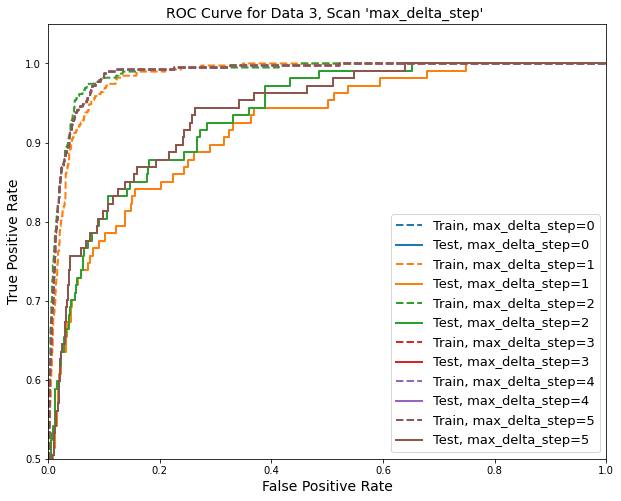

In [23]:
#Scan max_delta_step, 
#Model 2: max_depth=2, Default L1 & L2 (reg_lambda=1, reg_alpha=0), Default learning_rate=0.3

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 2,
    'min_child_weight': 1,
    'gamma': 0,
}

scanParam = 'max_delta_step'

scanList = [0, 1, 2, 3, 4, 5]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
max_delta_step=0 Train,0.974,0.741,0.673,0.705,0.979,0.012,0.016461
Test,0.968,0.729,0.579,0.646,0.924,0.012,0.016461
max_delta_step=0.25 Train,0.972,0.718,0.631,0.672,0.974,0.040,0.058997
Test,0.964,0.678,0.551,0.608,0.926,0.040,0.058997
max_delta_step=0.5 Train,0.976,0.774,0.680,0.724,0.982,0.100,0.148368
Test,0.963,0.674,0.542,0.601,0.929,0.100,0.148368
max_delta_step=0.75 Train,0.975,0.762,0.670,0.713,0.980,0.072,0.104348
Test,0.965,0.690,0.561,0.619,0.924,0.072,0.104348
max_delta_step=1 Train,0.975,0.749,0.686,0.716,0.981,0.086,0.129713


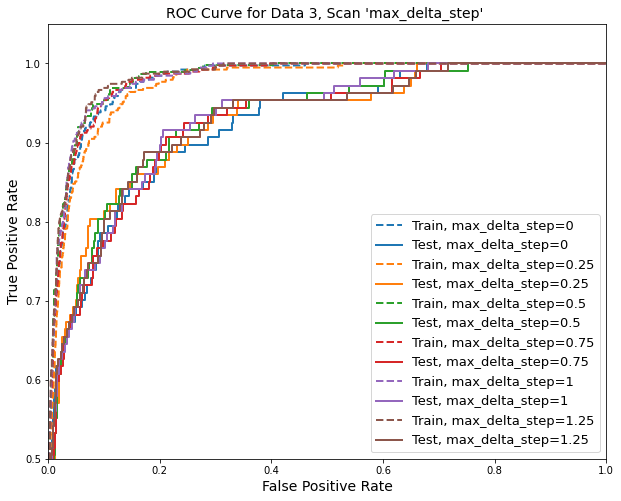

In [28]:
#Scan max_delta_step, 
#max_depth=3, Learning_rate=0.25, reg_lambda=0, reg_alpha=30

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 3,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 30,
    'learning_rate': 0.25
}

scanParam = 'max_delta_step'

scanList = [0, 0.25, 0.5, 0.75, 1, 1.25]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
max_delta_step=0 Train,0.976,0.770,0.673,0.718,0.976,-0.003,-0.003881
Test,0.969,0.773,0.542,0.637,0.929,-0.003,-0.003881
max_delta_step=0.25 Train,0.975,0.778,0.642,0.703,0.977,0.099,0.145803
Test,0.962,0.679,0.495,0.573,0.924,0.099,0.145803
max_delta_step=0.5 Train,0.974,0.762,0.644,0.698,0.976,0.051,0.071730
Test,0.964,0.711,0.505,0.590,0.925,0.051,0.071730
max_delta_step=0.75 Train,0.974,0.757,0.652,0.701,0.978,0.090,0.134933
Test,0.962,0.667,0.523,0.586,0.927,0.090,0.134933
max_delta_step=1 Train,0.975,0.763,0.655,0.705,0.979,0.116,0.179289


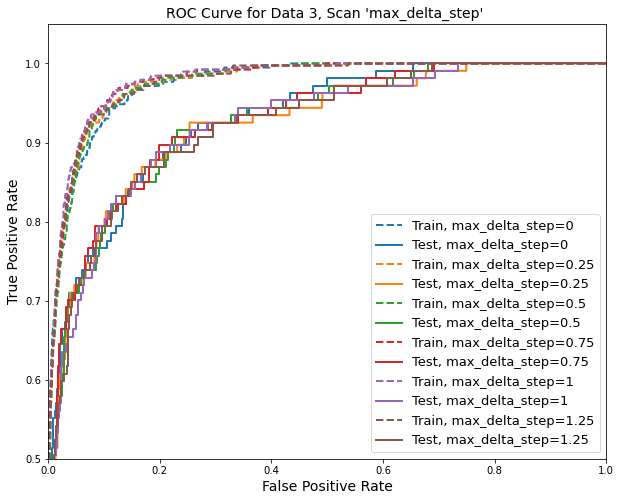

In [45]:
#Scan max_delta_step, 
#max_depth=5, Learning_rate=0.20, reg_lambda=0, reg_alpha=50

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20
}

scanParam = 'max_delta_step'

scanList = [0, 0.25, 0.5, 0.75, 1, 1.25]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

### Comments of Regularization

reg_lambda:
* The overfitting decreases for higher values of reg_lambda; however model performance drops
* Selected config: 
    * reg_lambda=500, max_depth=4  
* I will not use L2 regularization, since L1 performs better.

reg_alpha:
* The overfitting decreases for higher values of reg_alpha; however model performance drops
* Selected config: 
    * reg_alpha=30, max_depth=3
    * reg_alpha=50, max_depth=5 (better precision)
* I will use L1 for regularization.

learning_rate:
* Overfitting is smaller at lower values, however model performance drops
* Selected config: 
    * learning_rate=0.25, reg_alpha=30, max_depth=3
    * learning_rate=0.20, reg_alpha=50, max_depth=5 (better precision)

max_delta_step:
* There is no clear pattern for the effect on overfitting or model performance within the tested range.
* Selected config: max_delta_step=0, learning_rate=0.25, reg_alpha=30, max_depth=3


### Model 3: Model after Regularization

In [46]:
# Model 3: Model after Regularization

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20,
    'max_delta_step': 0
}

model_3 = XGBClassifier(**xgbParams)
model_3.fit(X_train, y_train)

print('Data3, Model 3:\n')
print('Training Data:\n', classification_report(y_train, model_3.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, model_3.predict(X_test)))

model_3.save_model('saved_model_history/xgb_model_3.json')

Data3, Model 3:

Training Data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      8014
           1       0.77      0.67      0.72       388

    accuracy                           0.98      8402
   macro avg       0.88      0.83      0.85      8402
weighted avg       0.97      0.98      0.97      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      1994
           1       0.77      0.54      0.64       107

    accuracy                           0.97      2101
   macro avg       0.87      0.77      0.81      2101
weighted avg       0.97      0.97      0.97      2101



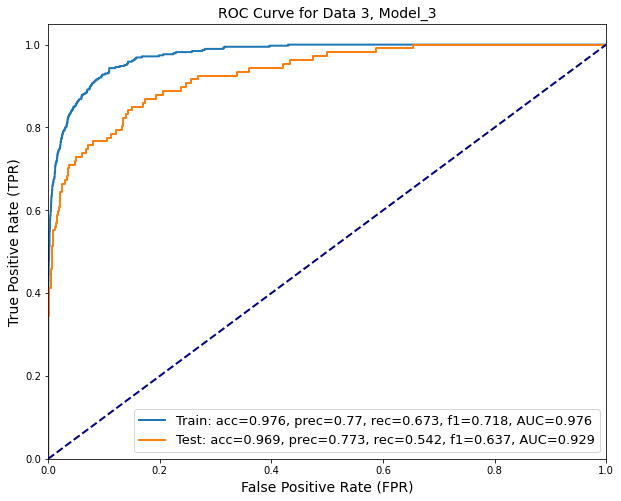

In [47]:
ROC_curve_train_test(3, X_train, y_train, X_test, y_test, model_3, 'Model_3', 1)

In [58]:
model_3.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=5, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=50, reg_lambda=0,
              scale_pos_weight=4.5, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

## Control Overfitting with Sampling

### subsample

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
subsample=0.5 Train,0.971,0.702,0.637,0.668,0.968,0.046,0.070122
Test,0.963,0.656,0.570,0.610,0.917,0.046,0.070122
subsample=0.6 Train,0.973,0.722,0.675,0.698,0.974,0.070,0.107362
Test,0.962,0.652,0.561,0.603,0.926,0.070,0.107362
subsample=0.7 Train,0.974,0.746,0.673,0.707,0.975,0.083,0.125189
Test,0.963,0.663,0.551,0.602,0.926,0.083,0.125189
subsample=0.8 Train,0.975,0.749,0.693,0.720,0.980,0.102,0.157651
Test,0.961,0.647,0.514,0.573,0.929,0.102,0.157651
subsample=0.9 Train,0.976,0.771,0.693,0.730,0.979,0.071,0.101429


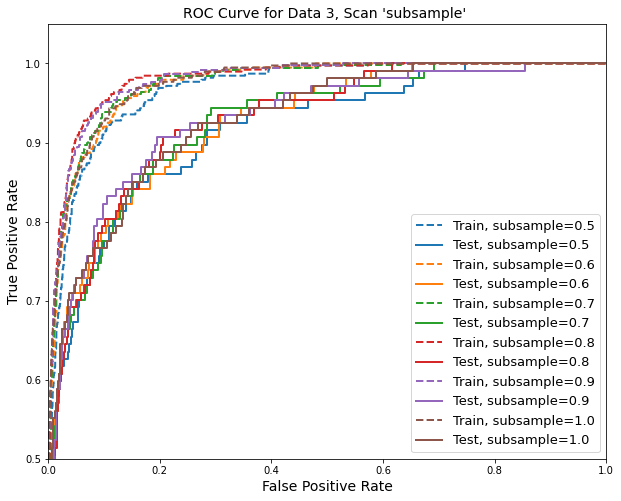

In [54]:
#Scan subsample, 
# Model 3 parameters

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20,
    'max_delta_step': 0
}

scanParam = 'subsample'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
subsample=0.5 Train,0.973,0.738,0.660,0.697,0.972,0.095,0.147745
Test,0.960,0.643,0.505,0.565,0.919,0.095,0.147745
subsample=0.6 Train,0.976,0.758,0.704,0.730,0.979,0.052,0.073654
Test,0.966,0.706,0.561,0.625,0.928,0.052,0.073654
subsample=0.7 Train,0.974,0.749,0.668,0.706,0.979,0.054,0.077698
Test,0.964,0.695,0.533,0.603,0.926,0.054,0.077698
subsample=0.8 Train,0.979,0.794,0.727,0.759,0.983,0.087,0.123055
Test,0.965,0.707,0.542,0.614,0.932,0.087,0.123055
subsample=0.9 Train,0.978,0.779,0.719,0.748,0.983,0.100,0.147275


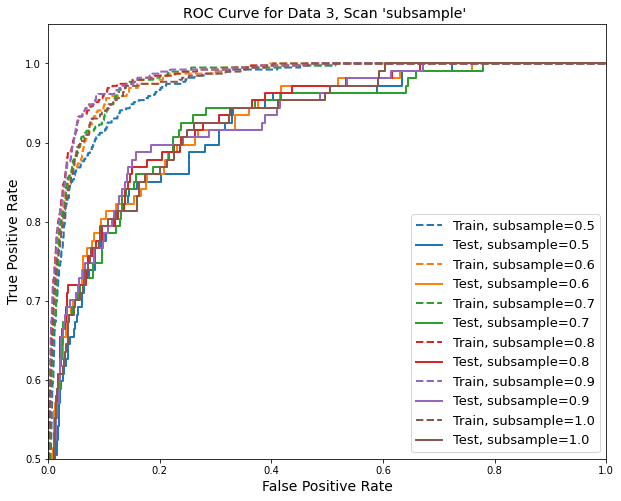

In [87]:
#Scan subsample, 
# max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20,
    'max_delta_step': 0
}

scanParam = 'subsample'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
subsample=0.5 Train,0.998,0.965,0.982,0.973,1.000,0.170,0.213836
Test,0.970,0.795,0.542,0.644,0.929,0.170,0.213836
subsample=0.6 Train,0.998,0.967,0.982,0.974,1.000,0.197,0.255844
Test,0.968,0.770,0.533,0.630,0.933,0.197,0.255844
subsample=0.7 Train,0.999,0.975,0.997,0.986,1.000,0.205,0.266234
Test,0.968,0.770,0.533,0.630,0.928,0.205,0.266234
subsample=0.8 Train,0.999,0.977,1.000,0.989,1.000,0.180,0.225847
Test,0.969,0.797,0.514,0.625,0.931,0.180,0.225847
subsample=0.9 Train,0.999,0.980,1.000,0.990,1.000,0.159,0.193666


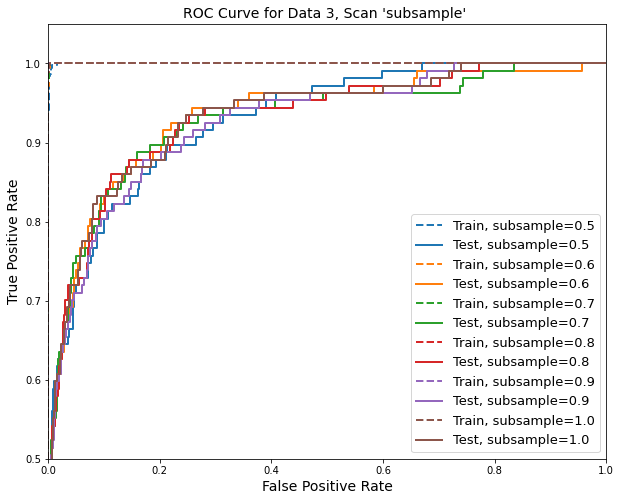

In [110]:
#Scan subsample, 
# 'max_depth': 6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 10,
    'learning_rate': 0.20,
    'max_delta_step': 0
}

scanParam = 'subsample'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList, 0)

### colsample_bytree

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
colsample_bytree=0.5 Train,0.974,0.758,0.629,0.687,0.973,0.032,0.044077
Test,0.965,0.726,0.495,0.589,0.925,0.032,0.044077
colsample_bytree=0.6 Train,0.975,0.772,0.644,0.702,0.973,0.025,0.033467
Test,0.968,0.747,0.551,0.634,0.928,0.025,0.033467
colsample_bytree=0.7 Train,0.975,0.770,0.657,0.709,0.973,0.082,0.119186
Test,0.963,0.688,0.495,0.576,0.923,0.082,0.119186
colsample_bytree=0.8 Train,0.974,0.751,0.660,0.702,0.975,0.001,0.001333
Test,0.966,0.750,0.505,0.603,0.926,0.001,0.001333
colsample_bytree=0.9 Train,0.974,0.758,0.655,0.703,0.976,0.005,0.006640


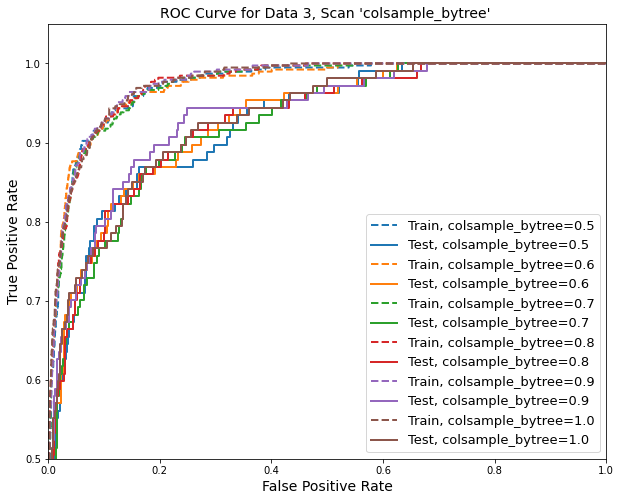

In [57]:
#Scan colsample_bytree
# Model 3 params

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 5,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20,
    'max_delta_step': 0,
}

scanParam = 'colsample_bytree'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
colsample_bytree=0.5 Train,0.977,0.804,0.668,0.730,0.980,0.086,0.119777
Test,0.964,0.718,0.477,0.573,0.931,0.086,0.119777
colsample_bytree=0.6 Train,0.977,0.805,0.670,0.731,0.980,0.038,0.049544
Test,0.968,0.767,0.523,0.622,0.927,0.038,0.049544
colsample_bytree=0.7 Train,0.978,0.809,0.678,0.738,0.979,0.108,0.154066
Test,0.964,0.701,0.505,0.587,0.929,0.108,0.154066
colsample_bytree=0.8 Train,0.975,0.779,0.655,0.711,0.977,0.070,0.098731
Test,0.965,0.709,0.523,0.602,0.925,0.070,0.098731
colsample_bytree=0.9 Train,0.977,0.778,0.696,0.735,0.981,0.053,0.073103


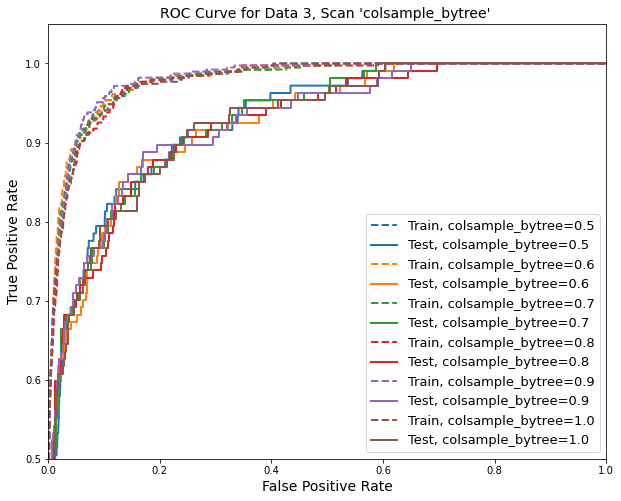

In [95]:
#Scan colsample_bytree
# max_depth=6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20,
    'max_delta_step': 0
}

scanParam = 'colsample_bytree'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
colsample_bytree=0.5 Train,0.977,0.804,0.668,0.730,0.980,0.086,0.119777
Test,0.964,0.718,0.477,0.573,0.931,0.086,0.119777
colsample_bytree=0.6 Train,0.977,0.805,0.670,0.731,0.980,0.038,0.049544
Test,0.968,0.767,0.523,0.622,0.927,0.038,0.049544
colsample_bytree=0.7 Train,0.978,0.809,0.678,0.738,0.979,0.108,0.154066
Test,0.964,0.701,0.505,0.587,0.929,0.108,0.154066
colsample_bytree=0.8 Train,0.975,0.779,0.655,0.711,0.977,0.070,0.098731
Test,0.965,0.709,0.523,0.602,0.925,0.070,0.098731
colsample_bytree=0.9 Train,0.977,0.778,0.696,0.735,0.981,0.053,0.073103


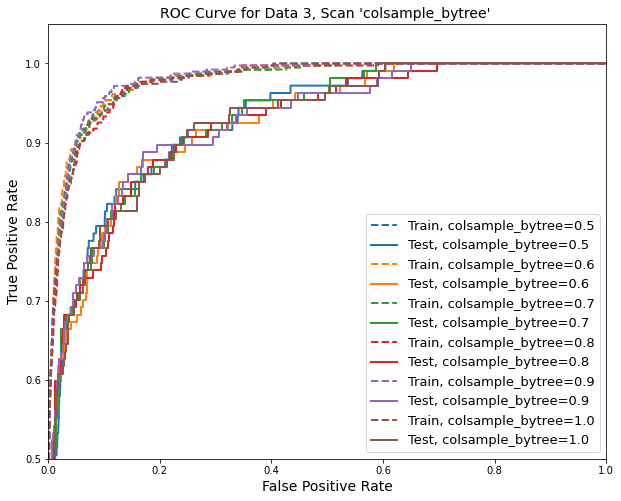

In [112]:
#Scan colsample_bytree
# max_depth=6, subsample=0.6

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'subsample': 1
}

scanParam = 'colsample_bytree'

scanList = [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)

### Comments on Sampling

subsample:
* The overfitting dependency on subsample is not significant within the tested range.
* Model performance drops some at lower subsample value
* I choose to use default parameter: subsample=1

colsample_bytree:
* The overfitting dependency on colsample_bytree is not significant within the tested range.
* Model performance is slightly better at low colsample_bytree values.
* Selected model:
    * colsample_bytree=1, learning_rate=0.20, reg_alpha=50, max_depth=5 (less overfitting, Model 3)
    * colsample_bytree=0.6, learning_rate=0.20, reg_alpha=50, max_depth=6 

### Model 4: Model after Sampling

* I created Model 4, just as an alternative, which uses max_depth=6
* Model 4 is not an improvement from Model 3
    * Model 4 overfitting is larger than Model 3.
    * Model 4 performance is sligtly worse than Model 3.


In [116]:
#Model 4: Model after Sampling

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 0.6
}

model_4 = XGBClassifier(**xgbParams)
model_4.fit(X_train, y_train)

print('Data3, Model 4:\n')
print('Training Data:\n', classification_report(y_train, model_4.predict(X_train)))
print('Testing Data:\n', classification_report(y_test, model_4.predict(X_test)))

model_4.save_model('saved_model_history/xgb_model_4.json')


Data3, Model 4:

Training Data:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99      8014
           1       0.80      0.67      0.73       388

    accuracy                           0.98      8402
   macro avg       0.89      0.83      0.86      8402
weighted avg       0.98      0.98      0.98      8402

Testing Data:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1994
           1       0.77      0.52      0.62       107

    accuracy                           0.97      2101
   macro avg       0.87      0.76      0.80      2101
weighted avg       0.96      0.97      0.96      2101



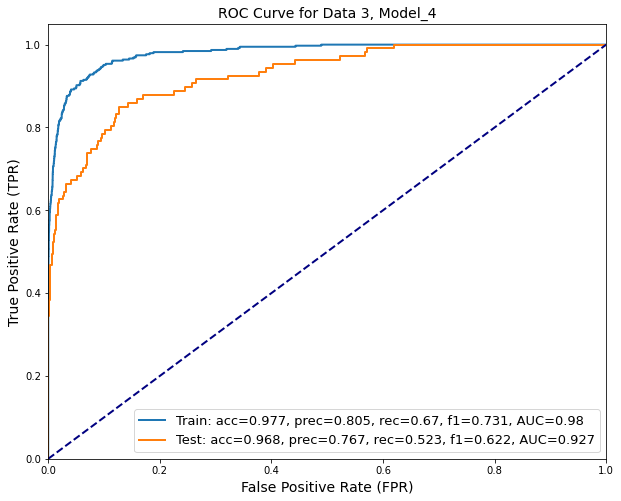

In [117]:
ROC_curve_train_test(3, X_train, y_train, X_test, y_test, model_4, 'Model_4', 1)

In [118]:
model_4.get_params

<bound method XGBModel.get_params of XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, eval_metric='logloss',
              gamma=0, gpu_id=-1, importance_type='gain',
              interaction_constraints='', learning_rate=0.2, max_delta_step=0,
              max_depth=6, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, random_state=42, reg_alpha=50, reg_lambda=0,
              scale_pos_weight=4.5, subsample=1, tree_method='exact',
              validate_parameters=1, verbosity=None)>

## Control Overfitting with Early Stopping


### early_stopping_rounds

[01:45:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[01:45:22] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { early_stopping_rounds } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




,accuracy,precision,recall,f1,auc,prec_diff,prec_diff_scaled
Params,,,,,,,
early_stopping_rounds=10 Train,0.977,0.805,0.670,0.731,0.980,0.038,0.049544
Test,0.968,0.767,0.523,0.622,0.927,0.038,0.049544
early_stopping_rounds=20 Train,0.977,0.805,0.670,0.731,0.980,0.038,0.049544
Test,0.968,0.767,0.523,0.622,0.927,0.038,0.049544


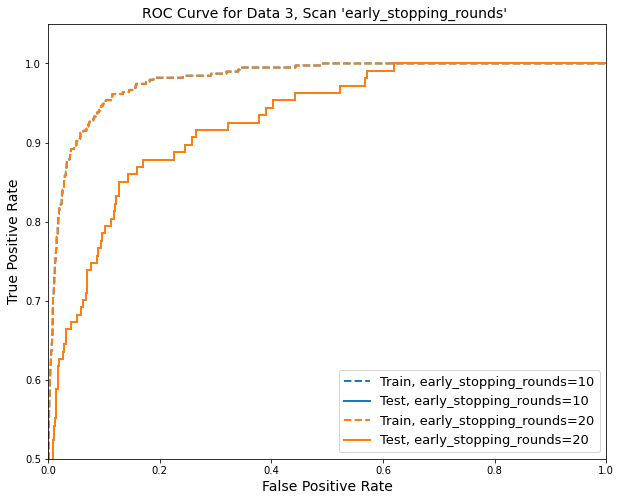

In [119]:
#Scan early_stopping_rounds

xgbParams = {
    'eval_metric': 'logloss', 
    'random_state': 42,
    'scale_pos_weight': 4.5,
    'max_depth': 6,
    'min_child_weight': 1,
    'gamma': 0,
    'reg_lambda': 0,
    'reg_alpha': 50,
    'learning_rate': 0.20,
    'max_delta_step': 0,
    'subsample': 1,
    'colsample_bytree': 0.6
}

scanParam = 'early_stopping_rounds'

scanList = [10, 20]

scan_xgb_overlay(3, X_train, y_train, X_test, y_test, xgbParams, scanParam, scanList)